<a href="https://colab.research.google.com/github/taareek/neural_netwok/blob/main/NN_Assignment_5a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### *Importing necessary Libraries and Downloading Dataset*

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

*Enabling GPU*

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


*Downloading CIFAR-10 Dataset*

In [4]:
batch_size = 40
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize( 
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) 
    )])
train_dataset = torchvision.datasets.CIFAR10(root= './data', train = True, download =True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(root= './data', train = False, download =True, transform = transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
total_step = len(train_loader)
print(total_step)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
1250


In [6]:
print('Training set samples:', len(train_dataset))
print('Test set samples:', len(test_dataset))

Training set samples: 50000
Test set samples: 10000


#### *Loading VGG-16 Network*

In [7]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

*Optimizer and Loss function*

In [19]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9, weight_decay= 5e-4)
# loss function
criterion = nn.CrossEntropyLoss()

*2 Layer VGG-16 Network*

In [20]:
class VGG16(nn.Module):
    def __init__(self, pretrained= True, numClasses= 10):
        super(VGG16, self).__init__()
        # conv1 
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        #conv2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size= 3, padding= 1)
        self.relu2_1 = nn.ReLU(inplace= True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # load pretrained params from torchvision.models.vgg16(pretrained=True)
        # From the original models.vgg16 (preconditioned = true).
        if pretrained:
            pretrained_model = torchvision.models.vgg16(pretrained=pretrained)  # Loading VGG16 network parameters from pre training model
            pretrained_params = pretrained_model.state_dict()
            keys = list(pretrained_params.keys())
            new_dict = {}
            for index, key in enumerate(self.state_dict().keys()):
                new_dict[key] = pretrained_params[keys[index]]
            self.load_state_dict(new_dict)

        self.classifier = nn.Sequential( 
            #nn.Linear(in_features=512 * 7 * 7, out_features=256),  # Custom network size after input.
            nn.Linear(in_features=8192 * 7 * 7, out_features=256),  # As we have taken 2 layers
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=256, out_features=numClasses),
        )
        
    def forward(self, x):   # output: 224 * 224 * 3
        x = self.relu1_1(self.conv1_1(x))  # output: 224 * 224 * 64
        x = self.relu1_2(self.conv1_2(x))  # output: 224 * 224 * 64
        x = self.pool1(x)  # output: 112 * 112 * 128

        x = self.relu2_1(self.conv2_1(x))
        x = self.relu2_2(self.conv2_2(x))
        x = self.pool2(x)
        #flattening
        x = x.view(x.size(0), -1)
        output = self.classifier(x)
        return output

*Training our VGG-16 model*

In [21]:
def vgg_16():
  epochs = 5 
  model = VGG16()
  if torch.cuda.is_available():
    model.cuda()

  for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      output = model(imgs)
      n_corrects = (output.argmax(axis= 1) == labels).sum().item()
      loss_value = criterion(output, labels)
      loss_value.backward()
      optimizer.step()
      optimizer.zero_grad()
      if (i+1) % 250 == 0:
        print(f'epoch {epoch+1}/{epochs}, step: {i+1}/{total_step}: loss = {loss_value:.5f}, acc = {100*(n_corrects/labels.size(0)):.2f}%')
    print()

*Printing loss value and accuracy*

In [22]:
vgg_16()

epoch 1/5, step: 250/1250: loss = 2.38887, acc = 7.50%
epoch 1/5, step: 500/1250: loss = 2.32893, acc = 12.50%
epoch 1/5, step: 750/1250: loss = 2.40619, acc = 5.00%
epoch 1/5, step: 1000/1250: loss = 2.39220, acc = 7.50%
epoch 1/5, step: 1250/1250: loss = 2.30105, acc = 10.00%

epoch 2/5, step: 250/1250: loss = 2.41578, acc = 5.00%
epoch 2/5, step: 500/1250: loss = 2.37190, acc = 10.00%
epoch 2/5, step: 750/1250: loss = 2.32739, acc = 10.00%
epoch 2/5, step: 1000/1250: loss = 2.44362, acc = 10.00%
epoch 2/5, step: 1250/1250: loss = 2.30793, acc = 5.00%

epoch 3/5, step: 250/1250: loss = 2.37842, acc = 7.50%
epoch 3/5, step: 500/1250: loss = 2.41249, acc = 5.00%
epoch 3/5, step: 750/1250: loss = 2.33537, acc = 5.00%
epoch 3/5, step: 1000/1250: loss = 2.41986, acc = 2.50%
epoch 3/5, step: 1250/1250: loss = 2.37213, acc = 17.50%

epoch 4/5, step: 250/1250: loss = 2.37152, acc = 7.50%
epoch 4/5, step: 500/1250: loss = 2.29753, acc = 22.50%
epoch 4/5, step: 750/1250: loss = 2.46004, acc = 

*Printing overall accuracy (F1 Score)*

In [29]:
def total_accuracy():
  model = VGG16()
  if torch.cuda.is_available():
    model.cuda()

  with torch.no_grad():
    number_samples = 0
    number_corrects = 0
    for i, (test_images_set, test_labels_set) in enumerate(test_loader):
      test_images_set = test_images_set.to(device)
      test_labels_set = test_labels_set.to(device)

      y_predicted = model(test_images_set)
      labels_predicted = y_predicted.argmax(axis = 1)        
      number_corrects += (labels_predicted==test_labels_set).sum().item()
      number_samples += test_labels_set.size(0)    
    print(f'Overall accuracy {(number_corrects / number_samples)*100}%')


In [30]:
# Overall accuracy
total_accuracy()

Overall accuracy 10.17%


*Confusion Matrix*

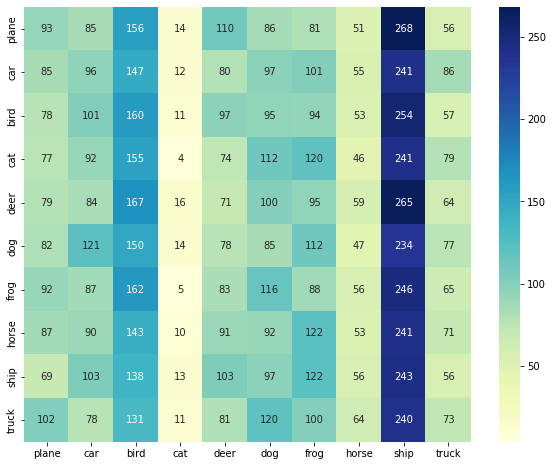

In [37]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#batch_size = 40

model = VGG16()
if torch.cuda.is_available():
  model.cuda()
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label,predicted_label] += 1
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d",cmap="YlGnBu")
plt.show()

*Save the model*

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
model = VGG16()
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/VGG16.pth')